# DTSA 5509-100
#### by S.Dioquino
* Objective: To develop supervised learning credit risk models that can predict the account's propensity of default, and to decide on best model to use
* Dataset: Kaggle open dataset, https://www.kaggle.com/yasserh/loan-default-dataset
    * Note: A data dictionary is not provided so some assumptions will be made
* GitHub: https://github.com/sdioq/dtsa5509_100

## Setting Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array, argmax
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

## Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('Loan_Default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [4]:
df.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [5]:
df['Status'].value_counts()

0    112031
1     36639
Name: Status, dtype: int64

In [6]:
sum(df['Status'])/len(df['Status'])

0.24644514696979888

In [7]:
cols = df.columns.tolist()
for i in cols:
    print(i, ":\n", df[i].value_counts(normalize = True), "\n")

ID :
 24890     0.000007
123979    0.000007
123999    0.000007
124000    0.000007
124001    0.000007
            ...   
74447     0.000007
74448     0.000007
74449     0.000007
74450     0.000007
173559    0.000007
Name: ID, Length: 148670, dtype: float64 

year :
 2019    1.0
Name: year, dtype: float64 

loan_limit :
 cf     0.931341
ncf    0.068659
Name: loan_limit, dtype: float64 

Gender :
 Male                 0.284832
Joint                0.278462
Sex Not Available    0.253306
Female               0.183399
Name: Gender, dtype: float64 

approv_in_adv :
 nopre    0.84339
pre      0.15661
Name: approv_in_adv, dtype: float64 

loan_type :
 type1    0.761236
type2    0.139652
type3    0.099112
Name: loan_type, dtype: float64 

loan_purpose :
 p3    0.376569
p4    0.368927
p1    0.232462
p2    0.022042
Name: loan_purpose, dtype: float64 

Credit_Worthiness :
 l1    0.957449
l2    0.042551
Name: Credit_Worthiness, dtype: float64 

open_credit :
 nopc    0.99626
opc     0.00374
Name: op

#### Dropping features with null > 5%

In [62]:
nulls = pd.DataFrame([np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   '])
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','NA','?','-', '.','', ' ', '   ']
b = []
tru = []
fal = []

for c in df.columns:
    x1 = ((df[c].isnull().sum() + np.array([x in a[2:] for x in df[c]]).sum())/148670) <= 0.05
    b.append([c, x1])
    
for key, val in b:
    if val == True:
        tru.append(key)
    else:
        fal.append(key)
print('Features to Include\n', tru, "\n\nFeatures to Drop\n", fal)

Features to Include
 ['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type', 'Status'] 

Features to Drop
 ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'LTV', 'dtir1']


In [9]:
df['income'].describe() #~6%

count    139520.000000
mean       6957.338876
std        6496.586382
min           0.000000
25%        3720.000000
50%        5760.000000
75%        8520.000000
max      578580.000000
Name: income, dtype: float64

In [10]:
df['LTV'].describe() #~10%

count    133572.000000
mean         72.746457
std          39.967603
min           0.967478
25%          60.474860
50%          75.135870
75%          86.184211
max        7831.250000
Name: LTV, dtype: float64

##### Target Feature
* Status: binary where 1 = default, 0 = non-default

##### Dropped Features
* Identifier
    * ID: not included
    * year: only one value
* Low concentrated bins that cannot be merged
    * Credit_Worthiness: unknown defn, will drop due to low concentration of l2 (<5%)
    * open_credit: if open credit or not, will drop due to low concentration of opc (<5%)
    * interest_only: if account pays only interest or not, will drop due to low concentration of int_only (<5%)
    * lump_sum_payment: if account pays lump sum, will drop due to low concentration of lpsm (<5%)
    * construction_type: unknown defn, will drop due to low concentration of mh (<5%)
    * Secured_by: very high concentration for home
    * total_units: very high concentration for 1U
    * Security_Type: very high concentration for direct
* High null values at >5%
    * rate_of_interest
    * Interest_rate_spread
    * Upfront_charges
    * property_value: in amount
    * income: in amount
    * LTV: loan to value 
    * dtir1: debt-to-income ratio

##### Included Features
* loan_limit:
    * cf = with credit facility
    * ncf = without credit facility
* Gender:
    * Male
    * Joint
    * Sex Not Available
    * Female
* approv_in_adv
    * nopre = no pre-approval
    * pre = pre-approved
* loan_type: unknown defn
* business_or_commeral:
    * nob/c = not business/commercial
    * b/c = business/commercial
* loan_amount
* term: in months
* Neg_ammortization: if account's structure uses negative amortization
    * not_neg = not using negative amortization
    * neg_amm = using negative amortization
* credit_type: unknown defn
* Credit_Score
* co-applicant_credit_type: unknown defn
* submission_of_application: where is the application submitted
    * to_inst = directly to the institution
    * not_inst = through a middleman or third party

##### Features to be Transformed, For Merging
* loan_purpose: unknown defn, merge p1 and p2 due to p2's small percentage (<5%)
* occupancy_type: unknown defn, merge ir and sr
* age: may need to merge <25, >74 with nearest band, may drop <25 due to very low concentration
* Region: may need to merge Central, and North-East to appropriate bands

In [11]:
df2 = df[['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 
 'loan_purpose', 'business_or_commercial', 'loan_amount', 'term', 'Neg_ammortization', 
 'occupancy_type', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 
 'Status']]

In [12]:
df2

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,term,Neg_ammortization,occupancy_type,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,nob/c,116500,360.0,not_neg,pr,EXP,758,CIB,25-34,to_inst,south,1
1,24891,2019,cf,Male,nopre,type2,p1,b/c,206500,360.0,not_neg,pr,EQUI,552,EXP,55-64,to_inst,North,1
2,24892,2019,cf,Male,pre,type1,p1,nob/c,406500,360.0,neg_amm,pr,EXP,834,CIB,35-44,to_inst,south,0
3,24893,2019,cf,Male,nopre,type1,p4,nob/c,456500,360.0,not_neg,pr,EXP,587,CIB,45-54,not_inst,North,0
4,24894,2019,cf,Joint,pre,type1,p1,nob/c,696500,360.0,not_neg,pr,CRIF,602,EXP,25-34,not_inst,North,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,nob/c,436500,180.0,not_neg,pr,CIB,659,EXP,55-64,to_inst,south,0
148666,173556,2019,cf,Male,nopre,type1,p1,nob/c,586500,360.0,not_neg,ir,CIB,569,CIB,25-34,not_inst,south,0
148667,173557,2019,cf,Male,nopre,type1,p4,nob/c,446500,180.0,not_neg,pr,CIB,702,EXP,45-54,not_inst,North,0
148668,173558,2019,cf,Female,nopre,type1,p4,nob/c,196500,180.0,not_neg,pr,EXP,737,EXP,55-64,to_inst,North,0


### Feature Transformation

##### Imputation
For variables with null/missing values:
* Use mode for categorical
    * loan_limit: 'cf'
    * approv_in_adv: 'nopre'
    * loan_purpose: 'p3'
    * Neg_ammortization: 'not_neg'
    * age: '45-54'
    * submission_of_application: 'to_inst'

* Use mean for numeric
    * term: '335'

In [13]:
df2['loan_limit'] = np.where(df2['loan_limit'].isnull(), 'cf', df2['loan_limit'])
df2['approv_in_adv'] = np.where(df2['approv_in_adv'].isnull(), 'nopre', df2['approv_in_adv'])
df2['loan_purpose'] = np.where(df2['loan_purpose'].isnull(), 'p3', df2['loan_purpose'])
df2['Neg_ammortization'] = np.where(df2['Neg_ammortization'].isnull(), 'not_neg', df2['Neg_ammortization'])
df2['age'] = np.where(df2['age'].isnull(), '45-54', df2['age'])
df2['submission_of_application'] = np.where(df2['submission_of_application'].isnull(), 'to_inst', df2['submission_of_application'])
df2['term'] = np.where(df2['term'].isnull(), 335.0, df2['term'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [14]:
#double-checking null values
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 148670 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              148670 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   term                       148670 non-null  float64
 10  Neg_ammortization          148670 non-null  object 
 11  occupancy_type             148670 non-null  object 
 12  credit_type                148670 non-null  object 
 13  Credit_Score               14

##### Merging Bins

In [15]:
#Function to summarize tables
def summ(a, i):
    a = a.groupby([i]).agg({'ID': 'count', 'Status': 'sum'}).reset_index()
    a.rename(columns = {"ID":"count", "Status":"bad"}, inplace = True)
    a['bad_rate'] = a['bad']/a['count']
    a['pct_total'] = a['count']/a['count'].sum()
    return a

In [16]:
ftures = ['loan_purpose', 'occupancy_type', 'age', 'Region']
for i in ftures:
    print(summ(df2, i), '\n\n')

  loan_purpose  count    bad  bad_rate  pct_total
0           p1  34529   8935  0.258768   0.232253
1           p2   3274   1083  0.330788   0.022022
2           p3  56068  14031  0.250250   0.377131
3           p4  54799  12590  0.229749   0.368595 


  occupancy_type   count    bad  bad_rate  pct_total
0             ir    7340   2201  0.299864   0.049371
1             pr  138201  33589  0.243045   0.929582
2             sr    3129    849  0.271333   0.021047 


     age  count   bad  bad_rate  pct_total
0  25-34  19142  4248  0.221920   0.128755
1  35-44  32818  7309  0.222713   0.220744
2  45-54  34920  8549  0.244817   0.234883
3  55-64  32534  8422  0.258868   0.218834
4  65-74  20744  5571  0.268560   0.139531
5    <25   1337   387  0.289454   0.008993
6    >74   7175  2153  0.300070   0.048261 


       Region  count    bad  bad_rate  pct_total
0       North  74722  16821  0.225114   0.502603
1  North-East   1235    376  0.304453   0.008307
2     central   8697   2395  0.275382 

In [17]:
df2['loan_purpose2'] = np.where(((df2['loan_purpose'] == 'p1') | (df2['loan_purpose'] == 'p2')), 'p1p2', df2['loan_purpose'])
df2['loan_purpose2'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p3      56068
p4      54799
p1p2    37803
Name: loan_purpose2, dtype: int64

In [18]:
df2['occupancy_type2'] = np.where(((df2['occupancy_type'] == 'ir') | (df2['occupancy_type'] == 'sr')), 'irsr', df2['occupancy_type'])
df2['occupancy_type2'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pr      138201
irsr     10469
Name: occupancy_type2, dtype: int64

In [19]:
df2['age2'] = np.where(((df2['age'] == '<25') | (df2['age'] == '25-34') | (df2['age'] == '35-44')), '1_<45', 
                      np.where(df2['age'] == '45-54', '2_45-54',
                      np.where(df2['age'] == '55-64', '3_55-64',
                      np.where(((df2['age'] == '>74') | (df2['age'] == '65-74')), '4_>64', df2['age']))))
df2['age2'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1_<45      53297
2_45-54    34920
3_55-64    32534
4_>64      27919
Name: age2, dtype: int64

In [20]:
df2['Region2'] = np.where(((df2['Region'] == 'North-East') | (df2['Region'] == 'central')), 'NE/Central', df2['Region'])
df2['Region2'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


North         74722
south         64016
NE/Central     9932
Name: Region2, dtype: int64

In [21]:
ftures2 = ['loan_purpose2', 'occupancy_type2', 'age2', 'Region2'] #note: for age2, <35 & 35-44 can actually be grouped together
for i in ftures2:
    print(summ(df2, i), '\n\n')

  loan_purpose2  count    bad  bad_rate  pct_total
0          p1p2  37803  10018  0.265005   0.254275
1            p3  56068  14031  0.250250   0.377131
2            p4  54799  12590  0.229749   0.368595 


  occupancy_type2   count    bad  bad_rate  pct_total
0            irsr   10469   3050  0.291336   0.070418
1              pr  138201  33589  0.243045   0.929582 


      age2  count    bad  bad_rate  pct_total
0    1_<45  53297  11944  0.224103   0.358492
1  2_45-54  34920   8549  0.244817   0.234883
2  3_55-64  32534   8422  0.258868   0.218834
3    4_>64  27919   7724  0.276657   0.187792 


      Region2  count    bad  bad_rate  pct_total
0  NE/Central   9932   2771  0.278997   0.066806
1       North  74722  16821  0.225114   0.502603
2       south  64016  17047  0.266293   0.430591 




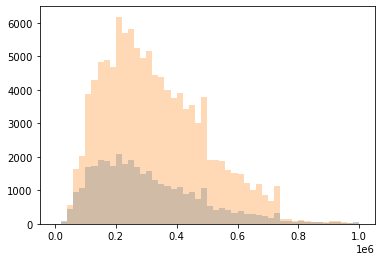

In [22]:
plt.hist(df2['loan_amount'][df2['Status'] == 1], alpha = 0.3, bins = 50, range = [0, 1000000])
plt.hist(df2['loan_amount'][df2['Status'] == 0], alpha = 0.3, bins = 50, range = [0, 1000000])
plt.show()

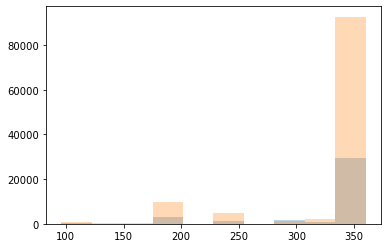

In [23]:
plt.hist(df2['term'][df2['Status'] == 1], alpha = 0.3, bins = 10)
plt.hist(df2['term'][df2['Status'] == 0], alpha = 0.3, bins = 10)
plt.show()

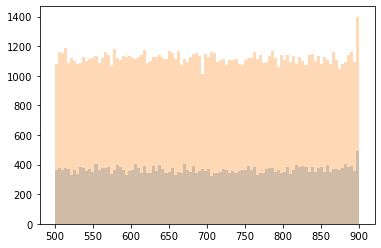

In [24]:
plt.hist(df2['Credit_Score'][df2['Status'] == 1], alpha = 0.3, bins = 100)
plt.hist(df2['Credit_Score'][df2['Status'] == 0], alpha = 0.3, bins = 100)
plt.show()

##### Label Encoding
* for variables with rank/trend

In [25]:
le = LabelEncoder()
df2["labeled_age2"] = le.fit_transform(df2["age2"])
df2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,term,...,co-applicant_credit_type,age,submission_of_application,Region,Status,loan_purpose2,occupancy_type2,age2,Region2,labeled_age2
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,nob/c,116500,360.0,...,CIB,25-34,to_inst,south,1,p1p2,pr,1_<45,south,0
1,24891,2019,cf,Male,nopre,type2,p1,b/c,206500,360.0,...,EXP,55-64,to_inst,North,1,p1p2,pr,3_55-64,North,2
2,24892,2019,cf,Male,pre,type1,p1,nob/c,406500,360.0,...,CIB,35-44,to_inst,south,0,p1p2,pr,1_<45,south,0
3,24893,2019,cf,Male,nopre,type1,p4,nob/c,456500,360.0,...,CIB,45-54,not_inst,North,0,p4,pr,2_45-54,North,1
4,24894,2019,cf,Joint,pre,type1,p1,nob/c,696500,360.0,...,EXP,25-34,not_inst,North,0,p1p2,pr,1_<45,North,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,nob/c,436500,180.0,...,EXP,55-64,to_inst,south,0,p3,pr,3_55-64,south,2
148666,173556,2019,cf,Male,nopre,type1,p1,nob/c,586500,360.0,...,CIB,25-34,not_inst,south,0,p1p2,irsr,1_<45,south,0
148667,173557,2019,cf,Male,nopre,type1,p4,nob/c,446500,180.0,...,EXP,45-54,not_inst,North,0,p4,pr,2_45-54,North,1
148668,173558,2019,cf,Female,nopre,type1,p4,nob/c,196500,180.0,...,EXP,55-64,to_inst,North,0,p4,pr,3_55-64,North,2


In [63]:
pd.crosstab(df2["age2"], df2["labeled_age2"])

labeled_age2,0,1,2,3
age2,,,,
1_<45,53297,0,0,0
2_45-54,0,34920,0,0
3_55-64,0,0,32534,0
4_>64,0,0,0,27919


##### One-Hot-Encoding
* Sources: 
    * https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
    * https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

In [26]:
#one-hot encoding
ohe_vars = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 
 'loan_purpose2', 'business_or_commercial', 'Neg_ammortization', 
 'occupancy_type2', 'credit_type', 'co-applicant_credit_type', 'submission_of_application', 'Region2']

In [27]:
df3 = df2
for i in ohe_vars:
    df3 = pd.get_dummies(df3, columns=[i], prefix=[i] )

In [28]:
df3.columns.tolist()

['ID',
 'year',
 'loan_purpose',
 'loan_amount',
 'term',
 'occupancy_type',
 'Credit_Score',
 'age',
 'Region',
 'Status',
 'age2',
 'labeled_age2',
 'loan_limit_cf',
 'loan_limit_ncf',
 'Gender_Female',
 'Gender_Joint',
 'Gender_Male',
 'Gender_Sex Not Available',
 'approv_in_adv_nopre',
 'approv_in_adv_pre',
 'loan_type_type1',
 'loan_type_type2',
 'loan_type_type3',
 'loan_purpose2_p1p2',
 'loan_purpose2_p3',
 'loan_purpose2_p4',
 'business_or_commercial_b/c',
 'business_or_commercial_nob/c',
 'Neg_ammortization_neg_amm',
 'Neg_ammortization_not_neg',
 'occupancy_type2_irsr',
 'occupancy_type2_pr',
 'credit_type_CIB',
 'credit_type_CRIF',
 'credit_type_EQUI',
 'credit_type_EXP',
 'co-applicant_credit_type_CIB',
 'co-applicant_credit_type_EXP',
 'submission_of_application_not_inst',
 'submission_of_application_to_inst',
 'Region2_NE/Central',
 'Region2_North',
 'Region2_south']

In [29]:
dropvars = ['year', 'loan_purpose', 'occupancy_type', 'age', 'Region', 'age2']
df4 = df3.drop(columns = dropvars)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 37 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ID                                  148670 non-null  int64  
 1   loan_amount                         148670 non-null  int64  
 2   term                                148670 non-null  float64
 3   Credit_Score                        148670 non-null  int64  
 4   Status                              148670 non-null  int64  
 5   labeled_age2                        148670 non-null  int32  
 6   loan_limit_cf                       148670 non-null  uint8  
 7   loan_limit_ncf                      148670 non-null  uint8  
 8   Gender_Female                       148670 non-null  uint8  
 9   Gender_Joint                        148670 non-null  uint8  
 10  Gender_Male                         148670 non-null  uint8  
 11  Gender_Sex Not Available  

#### Correlation and Multicollinearity
* Source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

In [30]:
#drop redundant vars affected by the dummy variable trap
dupvars = ['loan_limit_ncf', 'approv_in_adv_nopre', 'business_or_commercial_nob/c', 'Neg_ammortization_not_neg',
           'occupancy_type2_irsr', 'co-applicant_credit_type_EXP', 'submission_of_application_not_inst',
           'Gender_Sex Not Available', 'loan_purpose2_p1p2', 'credit_type_EQUI']

forcorr = df4.drop(columns = dupvars+['ID', 'Status', 'loan_type_type1', 'loan_type_type2', 'loan_type_type3', 'Region2_south'])

In [31]:
forcorr.shape

(148670, 21)

<AxesSubplot:>

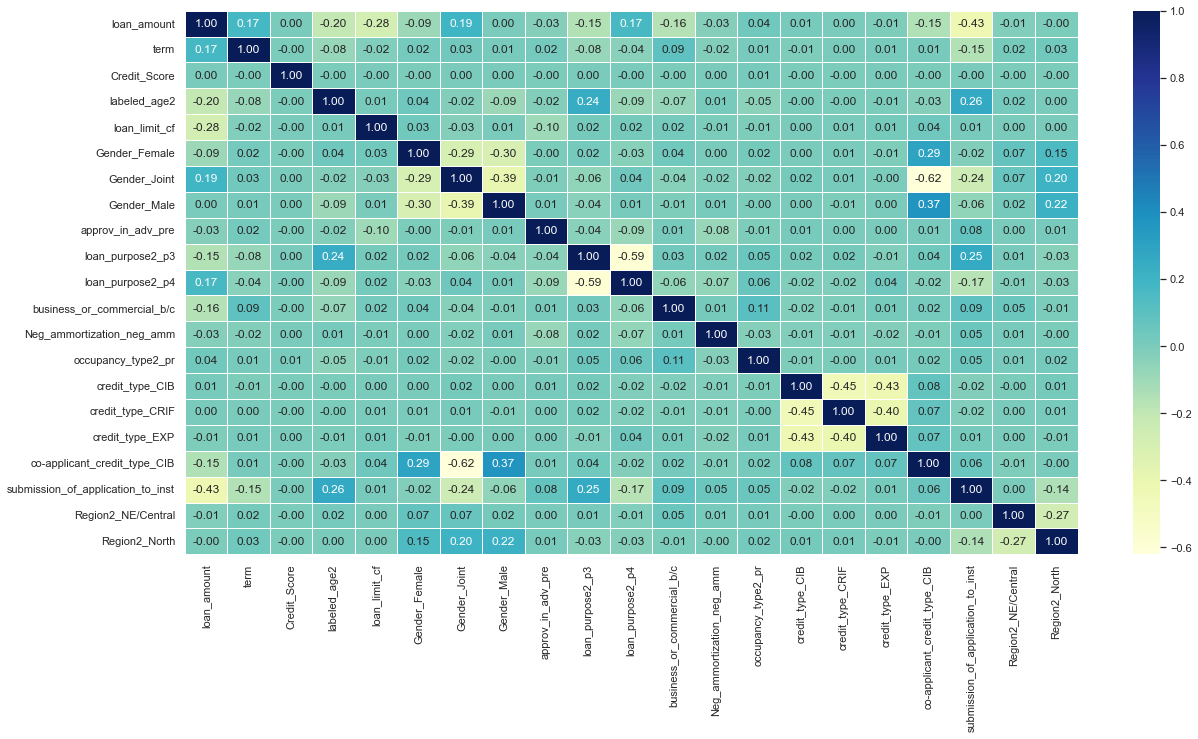

In [32]:
sns.set(font_scale = 1, rc = {'figure.figsize':(20,10)})
sns.heatmap(forcorr.corr(), annot = True, cmap ="YlGnBu", linecolor = 'white', linewidths = 0.5, fmt=".2f")

In [33]:
forcorr.corr().to_csv('corr.csv')

In [34]:
forcorr.columns.tolist()

['loan_amount',
 'term',
 'Credit_Score',
 'labeled_age2',
 'loan_limit_cf',
 'Gender_Female',
 'Gender_Joint',
 'Gender_Male',
 'approv_in_adv_pre',
 'loan_purpose2_p3',
 'loan_purpose2_p4',
 'business_or_commercial_b/c',
 'Neg_ammortization_neg_amm',
 'occupancy_type2_pr',
 'credit_type_CIB',
 'credit_type_CRIF',
 'credit_type_EXP',
 'co-applicant_credit_type_CIB',
 'submission_of_application_to_inst',
 'Region2_NE/Central',
 'Region2_North']

In [35]:
X = forcorr
  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]  
print(vif_data)

                              feature        VIF
0                         loan_amount   5.943833
1                                term  27.341649
2                        Credit_Score  27.017542
3                        labeled_age2   2.543241
4                       loan_limit_cf  14.109523
5                       Gender_Female   2.685741
6                        Gender_Joint   4.263733
7                         Gender_Male   3.581715
8                   approv_in_adv_pre   1.237507
9                    loan_purpose2_p3   2.797736
10                   loan_purpose2_p4   2.618620
11         business_or_commercial_b/c   1.253161
12          Neg_ammortization_neg_amm   1.132693
13                 occupancy_type2_pr  13.706246
14                    credit_type_CIB   5.026917
15                   credit_type_CRIF   4.664390
16                    credit_type_EXP   4.455624
17       co-applicant_credit_type_CIB   4.683294
18  submission_of_application_to_inst   3.959791
19                 R

In [36]:
#drop VIF > 10, be careful of VIF > 5
dropvif = ['term', 'Credit_Score', 'loan_limit_cf', 'occupancy_type2_pr']
X = forcorr.drop(columns = dropvif, axis = 1)
  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]  
print(vif_data)

                              feature       VIF
0                         loan_amount  4.065608
1                        labeled_age2  2.477796
2                       Gender_Female  2.516234
3                        Gender_Joint  4.005199
4                         Gender_Male  3.339355
5                   approv_in_adv_pre  1.221927
6                    loan_purpose2_p3  2.659344
7                    loan_purpose2_p4  2.412731
8          business_or_commercial_b/c  1.188439
9           Neg_ammortization_neg_amm  1.122997
10                    credit_type_CIB  4.215856
11                   credit_type_CRIF  3.909537
12                    credit_type_EXP  3.754466
13       co-applicant_credit_type_CIB  4.671214
14  submission_of_application_to_inst  3.207426
15                 Region2_NE/Central  1.376181
16                      Region2_North  3.730700


#### Finalizing Dataset

In [37]:
df_final = df4[X.columns.tolist() + ['Status']]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   loan_amount                        148670 non-null  int64
 1   labeled_age2                       148670 non-null  int32
 2   Gender_Female                      148670 non-null  uint8
 3   Gender_Joint                       148670 non-null  uint8
 4   Gender_Male                        148670 non-null  uint8
 5   approv_in_adv_pre                  148670 non-null  uint8
 6   loan_purpose2_p3                   148670 non-null  uint8
 7   loan_purpose2_p4                   148670 non-null  uint8
 8   business_or_commercial_b/c         148670 non-null  uint8
 9   Neg_ammortization_neg_amm          148670 non-null  uint8
 10  credit_type_CIB                    148670 non-null  uint8
 11  credit_type_CRIF                   148670 non-null  uint8
 12  cr

In [38]:
df_final['loan_amt_norm'] = (df_final['loan_amount']-np.min(df_final['loan_amount']))/(np.max(df_final['loan_amount'])-np.min(df_final['loan_amount']))
df_final['loan_amt_norm'].describe()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    148670.000000
mean          0.088376
std           0.051660
min           0.000000
25%           0.050562
50%           0.078652
75%           0.117978
max           1.000000
Name: loan_amt_norm, dtype: float64

In [39]:
df_final = df_final.drop(columns = ['loan_amount'], axis = 1)
df_final.columns.tolist()

['labeled_age2',
 'Gender_Female',
 'Gender_Joint',
 'Gender_Male',
 'approv_in_adv_pre',
 'loan_purpose2_p3',
 'loan_purpose2_p4',
 'business_or_commercial_b/c',
 'Neg_ammortization_neg_amm',
 'credit_type_CIB',
 'credit_type_CRIF',
 'credit_type_EXP',
 'co-applicant_credit_type_CIB',
 'submission_of_application_to_inst',
 'Region2_NE/Central',
 'Region2_North',
 'Status',
 'loan_amt_norm']

In [64]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_final.columns
vif_data["VIF"] = [variance_inflation_factor(df_final.values, i)
                          for i in range(len(df_final.columns))]  
print(vif_data)

                              feature       VIF
0                        labeled_age2  2.507977
1                       Gender_Female  2.552679
2                        Gender_Joint  4.067515
3                         Gender_Male  3.402317
4                   approv_in_adv_pre  1.221818
5                    loan_purpose2_p3  2.673240
6                    loan_purpose2_p4  2.437012
7          business_or_commercial_b/c  1.217658
8           Neg_ammortization_neg_amm  1.153882
9                     credit_type_CIB  4.877575
10                   credit_type_CRIF  4.498772
11                    credit_type_EXP  4.329731
12       co-applicant_credit_type_CIB  4.689966
13  submission_of_application_to_inst  3.592984
14                 Region2_NE/Central  1.376130
15                      Region2_North  3.731924
16                             Status  1.728665
17                      loan_amt_norm  4.175650


In [65]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   labeled_age2                       148670 non-null  int32  
 1   Gender_Female                      148670 non-null  uint8  
 2   Gender_Joint                       148670 non-null  uint8  
 3   Gender_Male                        148670 non-null  uint8  
 4   approv_in_adv_pre                  148670 non-null  uint8  
 5   loan_purpose2_p3                   148670 non-null  uint8  
 6   loan_purpose2_p4                   148670 non-null  uint8  
 7   business_or_commercial_b/c         148670 non-null  uint8  
 8   Neg_ammortization_neg_amm          148670 non-null  uint8  
 9   credit_type_CIB                    148670 non-null  uint8  
 10  credit_type_CRIF                   148670 non-null  uint8  
 11  credit_type_EXP                    1486

In [40]:
df_final.head()

,labeled_age2,Gender_Female,Gender_Joint,Gender_Male,approv_in_adv_pre,loan_purpose2_p3,loan_purpose2_p4,business_or_commercial_b/c,Neg_ammortization_neg_amm,credit_type_CIB,credit_type_CRIF,credit_type_EXP,co-applicant_credit_type_CIB,submission_of_application_to_inst,Region2_NE/Central,Region2_North,Status,loan_amt_norm
0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0.028090
1,2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0.053371
2,0,0,0,1,1,0,0,0,1,0,0,1,1,1,0,0,0,0.109551
3,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0.123596
4,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0.191011


In [41]:
#Train-Test Split
Xvars = df_final.drop(columns = ['Status'])
y = df_final[['Status']]
X_train, X_test, y_train, y_test = train_test_split(Xvars, y, test_size=0.30, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(104069, 17) (44601, 17) (104069, 1) (44601, 1)


### Logistic Regression

In [42]:
model_logit = sm.Logit(y_train, X_train)
result = model_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.389316
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:               104069
Model:                          Logit   Df Residuals:                   104052
Method:                           MLE   Df Model:                           16
Date:                Sun, 27 Feb 2022   Pseudo R-squ.:                  0.3045
Time:                        22:15:42   Log-Likelihood:                -40516.
converged:                       True   LL-Null:                       -58254.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
labeled_age2                          0.1519      0.008     17

In [43]:
#Train-Test Split, dropping insignificant var
Xvars = df_final.drop(columns = ['Status', 'Region2_NE/Central'])
y = df_final[['Status']]
X_train, X_test, y_train, y_test = train_test_split(Xvars, y, test_size=0.30, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(104069, 16) (44601, 16) (104069, 1) (44601, 1)


In [44]:
model_logit = sm.Logit(y_train, X_train)
result = model_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.389324
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:               104069
Model:                          Logit   Df Residuals:                   104053
Method:                           MLE   Df Model:                           15
Date:                Sun, 27 Feb 2022   Pseudo R-squ.:                  0.3045
Time:                        22:15:44   Log-Likelihood:                -40517.
converged:                       True   LL-Null:                       -58254.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
labeled_age2                          0.1523      0.008     18

In [45]:
model_logit = LogisticRegression().fit(X_train, y_train)
model_logit.score(X_test, y_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.8569763009797987

In [46]:
ytrain_pred = model_logit.predict(X_train)
print('TRAIN DATASET\nAccuracy: ', accuracy_score(y_train, ytrain_pred),
     '\nRecall: ', recall_score(y_train, ytrain_pred),
     '\nPrecision: ', precision_score(y_train, ytrain_pred),
     '\nF1: ', f1_score(y_train, ytrain_pred),
     '\nROC AUC: ', roc_auc_score(y_train, ytrain_pred),      
     '\nConfusion Matrix: \n', confusion_matrix(y_train, ytrain_pred))

TRAIN DATASET
Accuracy:  0.8572581652557438 
Recall:  0.43487875848690594 
Precision:  0.9748651939467734 
F1:  0.6014541357014461 
ROC AUC:  0.7155937716617737 
Confusion Matrix: 
 [[78005   289]
 [14566 11209]]


In [47]:
y_pred = model_logit.predict(X_test)
print('TEST DATASET\nAccuracy: ', accuracy_score(y_test, y_pred),
     '\nRecall: ', recall_score(y_test, y_pred),
     '\nPrecision: ', precision_score(y_test, y_pred),
     '\nF1: ', f1_score(y_test, y_pred),
     '\nROC AUC: ', roc_auc_score(y_test, y_pred),      
     '\nConfusion Matrix: \n', confusion_matrix(y_test, y_pred))

TEST DATASET
Accuracy:  0.8569763009797987 
Recall:  0.4270066273932253 
Precision:  0.9678698101397872 
F1:  0.5925783994379511 
ROC AUC:  0.7112209530836358 
Confusion Matrix: 
 [[33583   154]
 [ 6225  4639]]


Text(0.7, 0.2, 'AUC = 0.711')

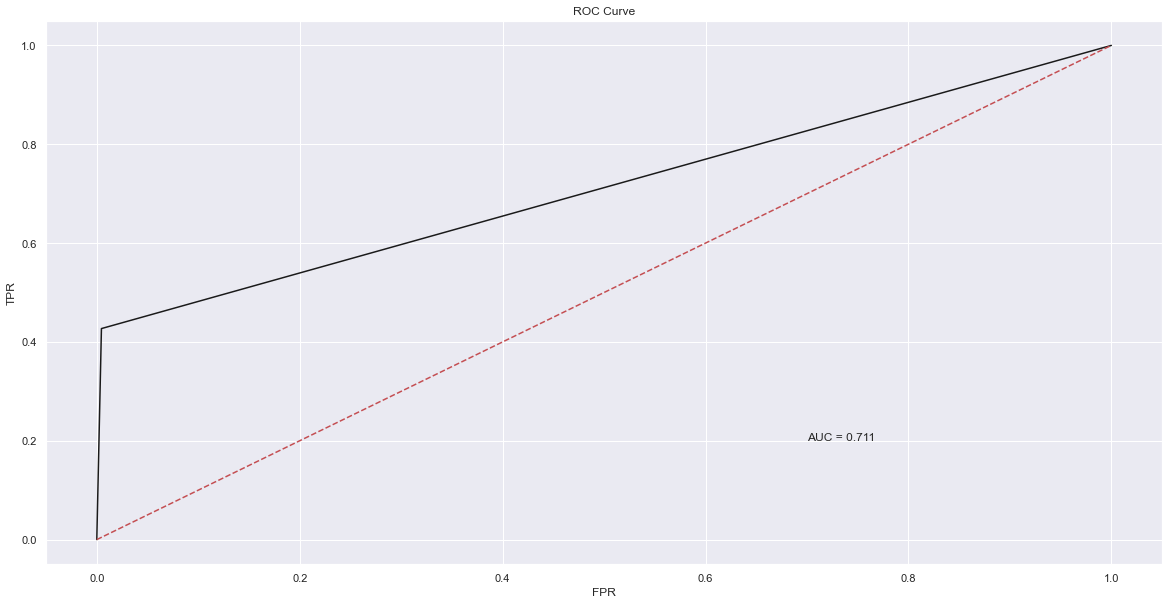

In [51]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "r--")
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC = '+"{:.3f}".format(auc))

### Decision Trees
* Source: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

In [52]:
model_dt = DecisionTreeClassifier(random_state = 101)
params = {
    'max_depth':range(3, 10), 'min_samples_leaf': range(10, 20), 'min_impurity_decrease': [0.001, 0.01, 0.1],
    'max_features': [None, 'auto']
}
grid_model_dt = GridSearchCV(model_dt, params)

In [53]:
grid_model_dt.fit(X_train, y_train)
grid_model_dt.best_estimator_

DecisionTreeClassifier(max_depth=6, min_impurity_decrease=0.001,
                       min_samples_leaf=10, random_state=101)

In [54]:
model_dt = DecisionTreeClassifier(random_state = 101, max_depth=6, min_impurity_decrease=0.001, min_samples_leaf=10)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_impurity_decrease=0.001,
                       min_samples_leaf=10, random_state=101)

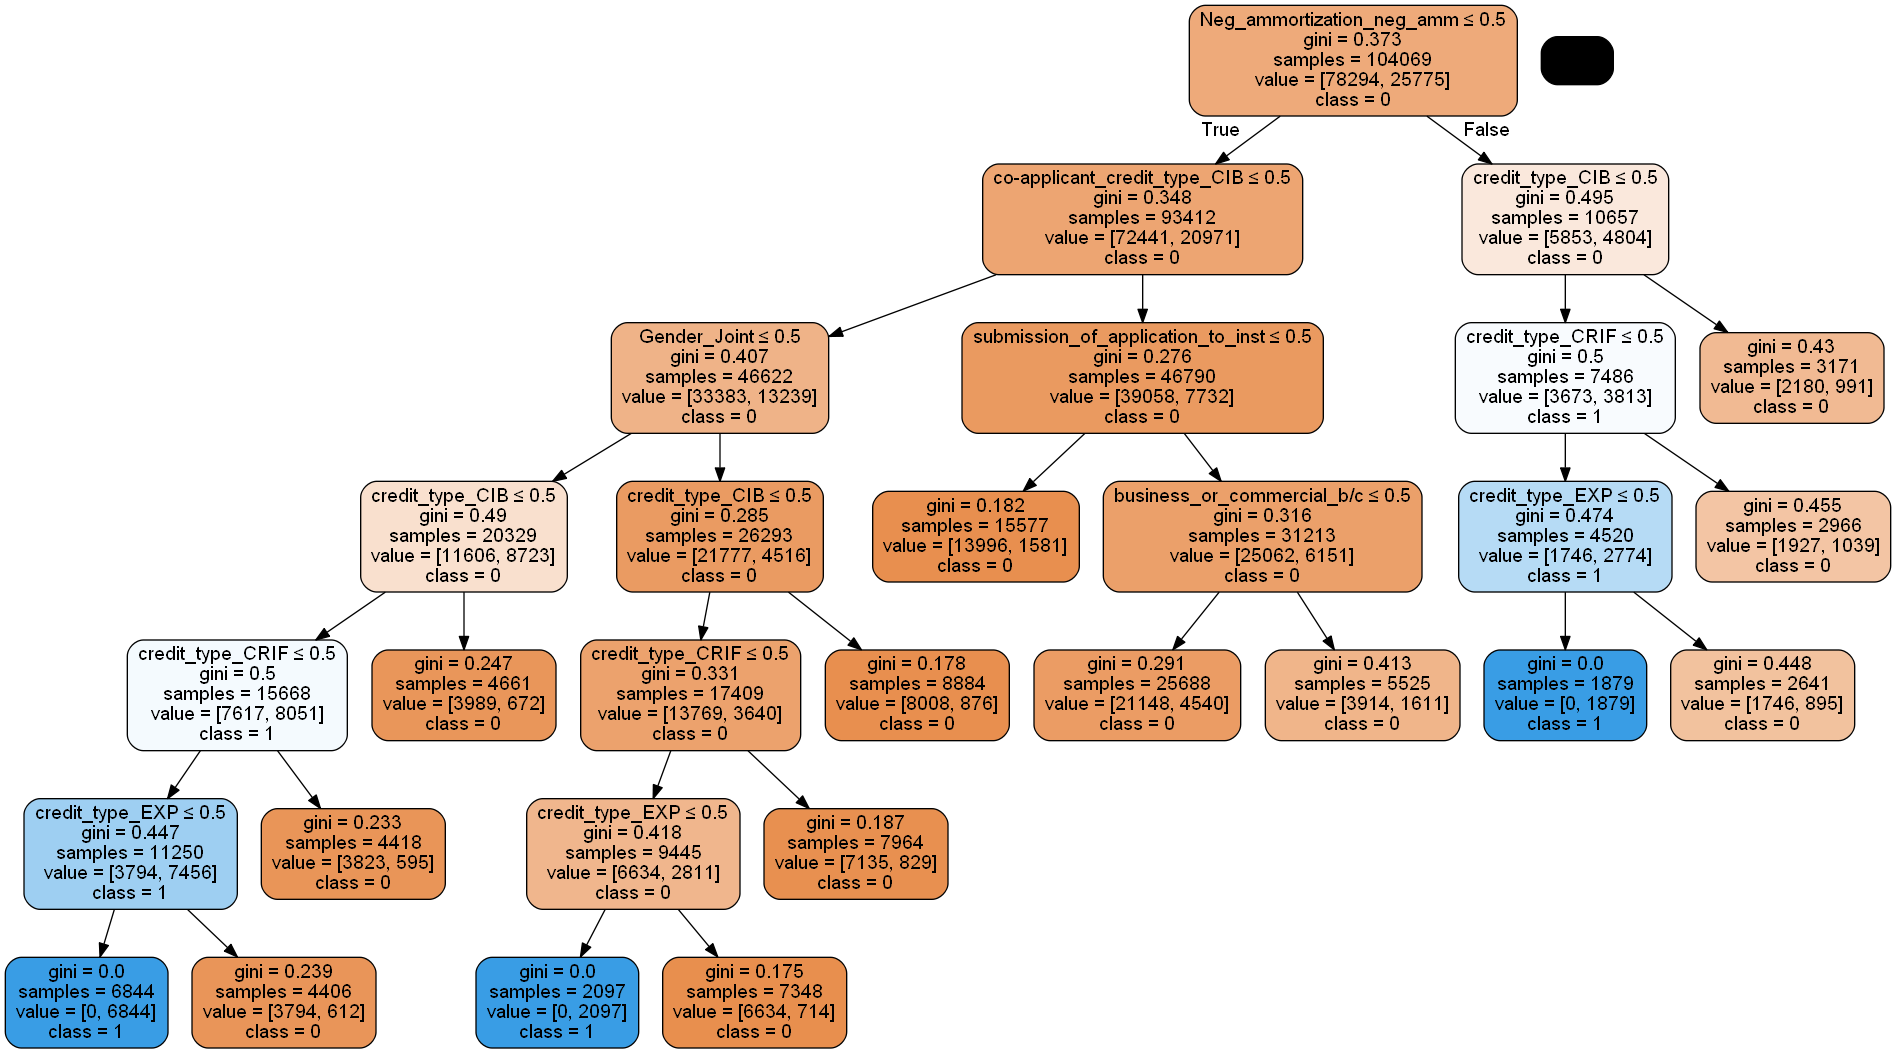

In [55]:
dot_data = StringIO()
feature_cols = X_train.columns.tolist()
export_graphviz(model_dt.fit(X_train, y_train), out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [56]:
model_dt.score(X_test, y_test)

0.8567745117822471

In [57]:
ytrain_pred = model_dt.predict(X_train)
print('TRAIN DATASET\nAccuracy: ', accuracy_score(y_train, ytrain_pred),
     '\nRecall: ', recall_score(y_train, ytrain_pred),
     '\nPrecision: ', precision_score(y_train, ytrain_pred),
     '\nF1: ', f1_score(y_train, ytrain_pred),
     '\nROC AUC: ', roc_auc_score(y_train, ytrain_pred),      
     '\nConfusion Matrix: \n', confusion_matrix(y_train, ytrain_pred))

TRAIN DATASET
Accuracy:  0.8562972643150217 
Recall:  0.4197866149369544 
Precision:  1.0 
F1:  0.5913376144282005 
ROC AUC:  0.7098933074684772 
Confusion Matrix: 
 [[78294     0]
 [14955 10820]]


In [58]:
y_pred = model_dt.predict(X_test)
print('TEST DATASET\nAccuracy: ', accuracy_score(y_test, y_pred),
     '\nRecall: ', recall_score(y_test, y_pred),
     '\nPrecision: ', precision_score(y_test, y_pred),
     '\nF1: ', f1_score(y_test, y_pred),
     '\nROC AUC: ', roc_auc_score(y_test, y_pred),      
     '\nConfusion Matrix: \n', confusion_matrix(y_test, y_pred))

TEST DATASET
Accuracy:  0.8567745117822471 
Recall:  0.4120029455081001 
Precision:  1.0 
F1:  0.5835723598435463 
ROC AUC:  0.70600147275405 
Confusion Matrix: 
 [[33737     0]
 [ 6388  4476]]


Text(0.7, 0.2, 'AUC = 0.706')

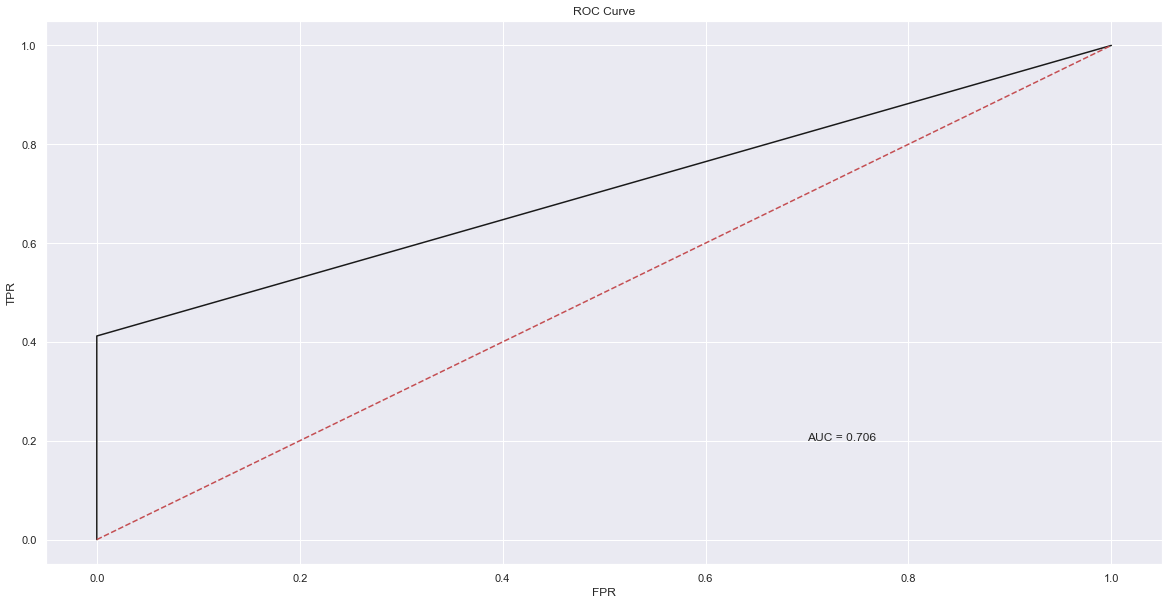

In [59]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "r--")
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC = '+"{:.3f}".format(auc))

### Random Forest

In [60]:
model_rf = RandomForestClassifier(random_state = 101, criterion = 'gini', max_features = 'sqrt', bootstrap = True, n_estimators = 100)
params = {'max_depth':range(3, 10), 'min_samples_leaf': range(10, 20), 'min_impurity_decrease': [0.001, 0.01, 0.1]}
grid_model_rf = GridSearchCV(model_rf, params)

In [61]:
grid_model_rf.fit(X_train, y_train.values.ravel())
grid_model_rf.best_estimator_

RandomForestClassifier(max_depth=9, max_features='sqrt',
                       min_impurity_decrease=0.001, min_samples_leaf=10,
                       random_state=101)

In [71]:
model_rf = RandomForestClassifier(random_state = 101, criterion = 'gini', max_features = 'sqrt', bootstrap = True, n_estimators = 100,
                                  max_depth=9, min_impurity_decrease=0.001, min_samples_leaf=10)
model_rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=9, max_features='sqrt',
                       min_impurity_decrease=0.001, min_samples_leaf=10,
                       random_state=101)

In [72]:
ytrain_pred = model_rf.predict(X_train)
print('TRAIN DATASET\nAccuracy: ', accuracy_score(y_train, ytrain_pred),
     '\nRecall: ', recall_score(y_train, ytrain_pred),
     '\nPrecision: ', precision_score(y_train, ytrain_pred),
     '\nF1: ', f1_score(y_train, ytrain_pred),
     '\nROC AUC: ', roc_auc_score(y_train, ytrain_pred),
     '\nConfusion Matrix: \n', confusion_matrix(y_train, ytrain_pred))

TRAIN DATASET
Accuracy:  0.8321306056558629 
Recall:  0.3222114451988361 
Precision:  1.0 
F1:  0.48738262910798125 
ROC AUC:  0.661105722599418 
Confusion Matrix: 
 [[78294     0]
 [17470  8305]]


In [73]:
y_pred = model_rf.predict(X_test)
print('TEST DATASET\nAccuracy: ', accuracy_score(y_test, y_pred),
     '\nRecall: ', recall_score(y_test, y_pred),
     '\nPrecision: ', precision_score(y_test, y_pred),
     '\nF1: ', f1_score(y_test, y_pred),
     '\nROC AUC: ', roc_auc_score(y_test, y_pred),
     '\nConfusion Matrix: \n', confusion_matrix(y_test, y_pred),
     )

TEST DATASET
Accuracy:  0.8338826483711127 
Recall:  0.3180228276877761 
Precision:  1.0 
F1:  0.4825755988546686 
ROC AUC:  0.6590114138438881 
Confusion Matrix: 
 [[33737     0]
 [ 7409  3455]]


Text(0.7, 0.2, 'AUC = 0.659')

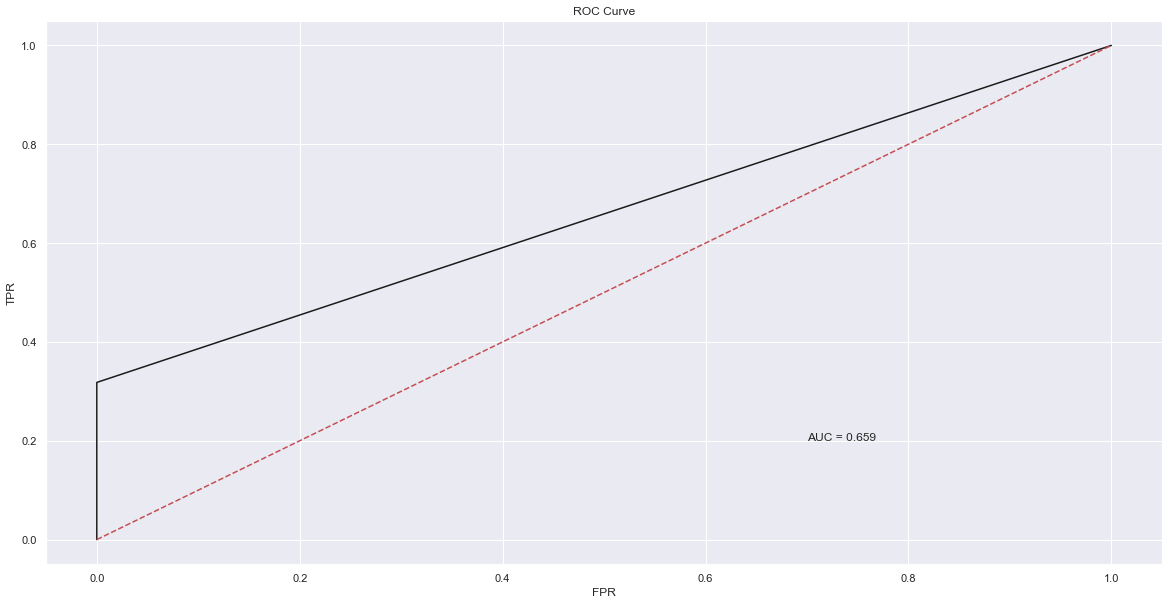

In [74]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "r--")
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC = '+"{:.3f}".format(auc))

In [75]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model_rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
9,credit_type_CIB,0.224546
10,credit_type_CRIF,0.184703
11,credit_type_EXP,0.184330
12,co-applicant_credit_type_CIB,0.121066
8,Neg_ammortization_neg_amm,0.103941
2,Gender_Joint,0.066562
13,submission_of_application_to_inst,0.036385
3,Gender_Male,0.026703
7,business_or_commercial_b/c,0.025035
1,Gender_Female,0.013505


##### Test: removing grid search hyperparameters
* significant overfitting observed

In [92]:
model_rf = RandomForestClassifier(random_state = 101, criterion = 'gini', max_features = 'sqrt', bootstrap = True, n_estimators = 100)
model_rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_features='sqrt', random_state=101)

In [93]:
ytrain_pred = model_rf.predict(X_train)
print('TRAIN DATASET\nAccuracy: ', accuracy_score(y_train, ytrain_pred),
     '\nRecall: ', recall_score(y_train, ytrain_pred),
     '\nPrecision: ', precision_score(y_train, ytrain_pred),
     '\nF1: ', f1_score(y_train, ytrain_pred),
     '\nROC AUC: ', roc_auc_score(y_train, ytrain_pred),
     '\nConfusion Matrix: \n', confusion_matrix(y_train, ytrain_pred))

TRAIN DATASET
Accuracy:  0.9264910780347654 
Recall:  0.7386226964112512 
Precision:  0.9542378828128916 
F1:  0.8326991208502821 
ROC AUC:  0.8634807609320159 
Confusion Matrix: 
 [[77381   913]
 [ 6737 19038]]


In [94]:
y_pred = model_rf.predict(X_test)
print('TEST DATASET\nAccuracy: ', accuracy_score(y_test, y_pred),
     '\nRecall: ', recall_score(y_test, y_pred),
     '\nPrecision: ', precision_score(y_test, y_pred),
     '\nF1: ', f1_score(y_test, y_pred),
     '\nROC AUC: ', roc_auc_score(y_test, y_pred),
     '\nConfusion Matrix: \n', confusion_matrix(y_test, y_pred),
     )

TEST DATASET
Accuracy:  0.8209232976839085 
Recall:  0.5052466863033873 
Precision:  0.6775706702876189 
F1:  0.5788557869760085 
ROC AUC:  0.7139121358718525 
Confusion Matrix: 
 [[31125  2612]
 [ 5375  5489]]


Text(0.7, 0.2, 'AUC = 0.714')

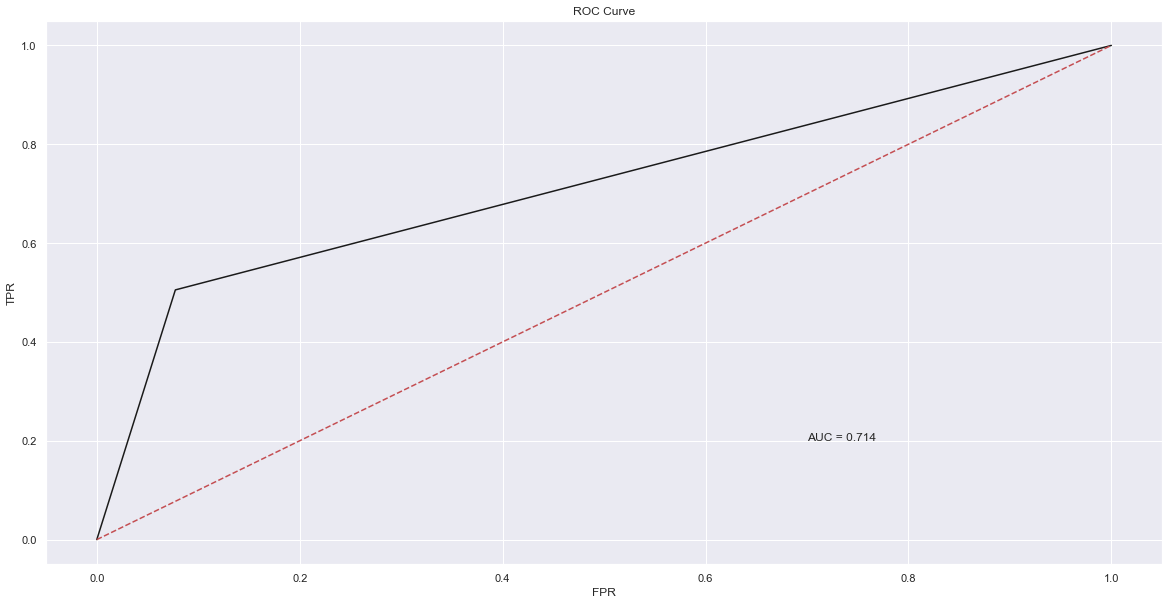

In [95]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "r--")
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC = '+"{:.3f}".format(auc))

In [96]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model_rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
15,loan_amt_norm,0.382861
10,credit_type_CRIF,0.129470
11,credit_type_EXP,0.119685
9,credit_type_CIB,0.110951
0,labeled_age2,0.052032
12,co-applicant_credit_type_CIB,0.042534
8,Neg_ammortization_neg_amm,0.027986
2,Gender_Joint,0.020906
13,submission_of_application_to_inst,0.016437
3,Gender_Male,0.016277


### XGBoost
* Source: https://xgboost.readthedocs.io/en/stable/python/python_intro.html
* Source: https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/

In [81]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
dtrain = xgb.DMatrix(data = X_train, label=y_train)
dtest = xgb.DMatrix(data = X_test, label=y_test)

In [82]:
num_round = 200
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evals = evallist, early_stopping_rounds=10)
print(bst.best_score, bst.best_iteration)

[0]	eval-auc:0.61806	train-auc:0.62113
[1]	eval-auc:0.67251	train-auc:0.67543
[2]	eval-auc:0.71363	train-auc:0.71823
[3]	eval-auc:0.73198	train-auc:0.73650
[4]	eval-auc:0.74896	train-auc:0.75703
[5]	eval-auc:0.75635	train-auc:0.76320
[6]	eval-auc:0.77309	train-auc:0.77897
[7]	eval-auc:0.77966	train-auc:0.78461
[8]	eval-auc:0.77658	train-auc:0.78229
[9]	eval-auc:0.78499	train-auc:0.79021
[10]	eval-auc:0.79014	train-auc:0.79513
[11]	eval-auc:0.79283	train-auc:0.79677
[12]	eval-auc:0.79461	train-auc:0.79981
[13]	eval-auc:0.79544	train-auc:0.80082
[14]	eval-auc:0.79767	train-auc:0.80161
[15]	eval-auc:0.79986	train-auc:0.80419
[16]	eval-auc:0.80158	train-auc:0.80534
[17]	eval-auc:0.80130	train-auc:0.80502
[18]	eval-auc:0.80197	train-auc:0.80591
[19]	eval-auc:0.80174	train-auc:0.80532
[20]	eval-auc:0.80260	train-auc:0.80630
[21]	eval-auc:0.80259	train-auc:0.80657
[22]	eval-auc:0.80325	train-auc:0.80708
[23]	eval-auc:0.80345	train-auc:0.80765
[24]	eval-auc:0.80384	train-auc:0.80825
[25]	eval-

In [83]:
num_round = 150
evallist = [(dtest, 'eval'), (dtrain, 'train')]
model_xgb = xgb.train(param, dtrain, num_round, evals = evallist, early_stopping_rounds=10)
print(model_xgb.best_score, model_xgb.best_iteration)

[0]	eval-auc:0.61806	train-auc:0.62113
[1]	eval-auc:0.67251	train-auc:0.67543
[2]	eval-auc:0.71363	train-auc:0.71823
[3]	eval-auc:0.73198	train-auc:0.73650
[4]	eval-auc:0.74896	train-auc:0.75703
[5]	eval-auc:0.75635	train-auc:0.76320
[6]	eval-auc:0.77309	train-auc:0.77897
[7]	eval-auc:0.77966	train-auc:0.78461
[8]	eval-auc:0.77658	train-auc:0.78229
[9]	eval-auc:0.78499	train-auc:0.79021
[10]	eval-auc:0.79014	train-auc:0.79513
[11]	eval-auc:0.79283	train-auc:0.79677
[12]	eval-auc:0.79461	train-auc:0.79981
[13]	eval-auc:0.79544	train-auc:0.80082
[14]	eval-auc:0.79767	train-auc:0.80161
[15]	eval-auc:0.79986	train-auc:0.80419
[16]	eval-auc:0.80158	train-auc:0.80534
[17]	eval-auc:0.80130	train-auc:0.80502
[18]	eval-auc:0.80197	train-auc:0.80591
[19]	eval-auc:0.80174	train-auc:0.80532
[20]	eval-auc:0.80260	train-auc:0.80630
[21]	eval-auc:0.80259	train-auc:0.80657
[22]	eval-auc:0.80325	train-auc:0.80708
[23]	eval-auc:0.80345	train-auc:0.80765
[24]	eval-auc:0.80384	train-auc:0.80825
[25]	eval-

In [84]:
ytrain_pred = pd.DataFrame((model_xgb.predict(dtrain) > 0.5).astype(int))  
print('TRAIN DATASET\nAccuracy: ', accuracy_score(y_train, ytrain_pred),
     '\nRecall: ', recall_score(y_train, ytrain_pred),
     '\nPrecision: ', precision_score(y_train, ytrain_pred),
     '\nF1: ', f1_score(y_train, ytrain_pred),
     '\nROC AUC: ', roc_auc_score(y_train, ytrain_pred),
     '\nConfusion Matrix: \n', confusion_matrix(y_train, ytrain_pred))

TRAIN DATASET
Accuracy:  0.8587667797326773 
Recall:  0.44954413191076625 
Precision:  0.9578407869719765 
F1:  0.6119032530629489 
ROC AUC:  0.7215151113994784 
Confusion Matrix: 
 [[77784   510]
 [14188 11587]]


In [85]:
y_pred = pd.DataFrame((model_xgb.predict(dtest) > 0.5).astype(int))  
print('TEST DATASET\nAccuracy: ', accuracy_score(y_test, y_pred),
     '\nRecall: ', recall_score(y_test, y_pred),
     '\nPrecision: ', precision_score(y_test, y_pred),
     '\nF1: ', f1_score(y_test, y_pred),
     '\nROC AUC: ', roc_auc_score(y_test, y_pred),
     '\nConfusion Matrix: \n', confusion_matrix(y_test, y_pred),
     )

TEST DATASET
Accuracy:  0.8574247214188022 
Recall:  0.43961708394698085 
Precision:  0.9463047354864276 
F1:  0.6003393878448872 
ROC AUC:  0.7157921801155895 
Confusion Matrix: 
 [[33466   271]
 [ 6088  4776]]


Text(0.7, 0.2, 'AUC = 0.716')

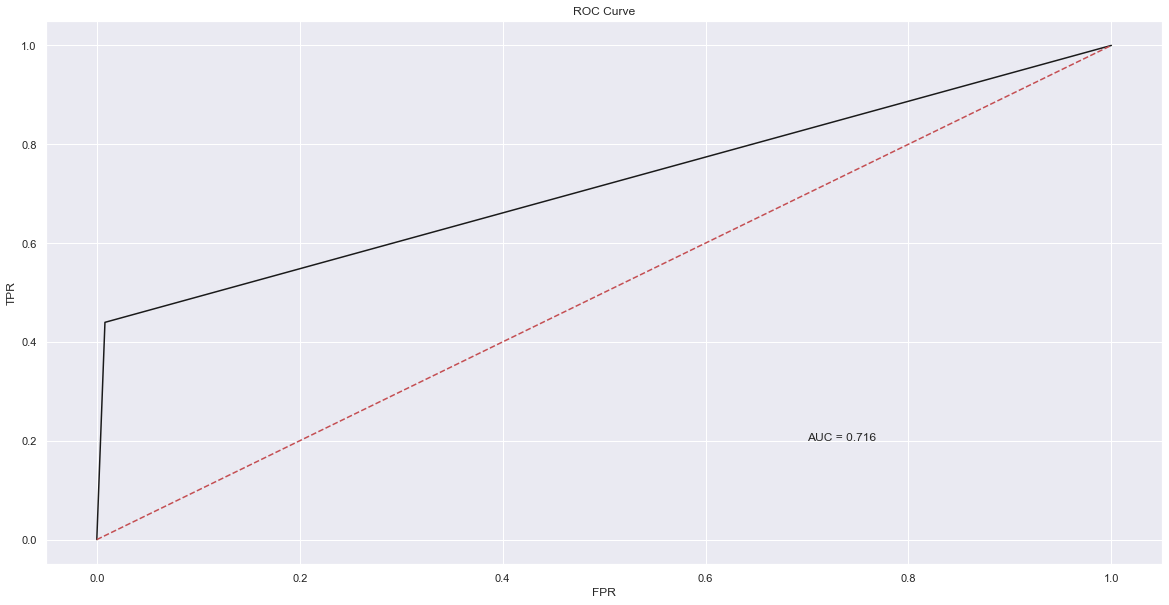

In [86]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "r--")
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC = '+"{:.3f}".format(auc))

In [87]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)

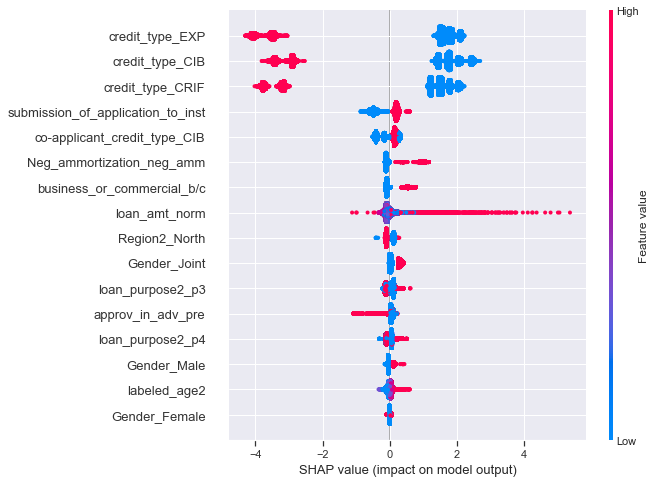

In [89]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

### Final Thoughts
In conclusion, the choice of the final model will depend on the objective of the financial institution. Decision tree and random forest models have the highest precision, which is beneficial if FIs are looking at accepting more applicants and predicting bads only if the certainty of default is mostly certain. However, both models have issues in terms of the business sense of some variables and overall implementation. Hence, they may not be the best choice. On the other hand, Logistic and XGB perform well and the performance values are mostly similar. However, XGB, in this case is more conservative as it classified more borrowers as default. Ultimately, the choice of the model to be implemented is dependent on the FI’s risk appetite and objective. However, in this case, since the difference is not that big, I may look into using the logistic model instead since it’s simpler and I won’t be losing more good borrowers that were falsely tagged as bad (see confusion matrix for reference).

* For more details on the analyses, please refer to the spiel document uploaded in GitHub.